In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import sys

DRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/IoT_Inverting Gradients'

sys.path.append(DRIVE_PATH)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [ ]:
arch = 'ResNet32-10'
num_images = 100
trained_model = True

## System setup:

In [ ]:
import inversefed
import os

setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR100', defs)

model, _ = inversefed.construct_model(arch, num_classes=100, num_channels=3)
model.to(**setup)
if trained_model:
    defs.epochs = 10
    file = f'{arch}_{defs.epochs}.pth'
    load_path = os.path.join(DRIVE_PATH, 'models', file)
    try:
        state_dict = torch.load(load_path)
        model.load_state_dict(state_dict)
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        save_path = os.path.join(DRIVE_PATH, 'models', file)
        torch.save(model.state_dict(), save_path)
model.eval();

Currently evaluating -------------------------------:
Monday, 17. November 2025 09:54AM
CPUs: 1, GPUs: 1 on 3ca68392ab47.
GPU : Tesla T4


100%|██████████| 169M/169M [00:05<00:00, 33.5MB/s]


Model initialized with random key 3849123403.


In [ ]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

In [ ]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255,
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

In [ ]:
def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)

    fig, axes = plt.subplots(10, 10, figsize=(24, 24))
    for im, l, ax in zip(tensor, labels, axes.flatten()):
        ax.imshow(im.permute(1, 2, 0).cpu());
        ax.set_title(l)
        ax.axis('off')

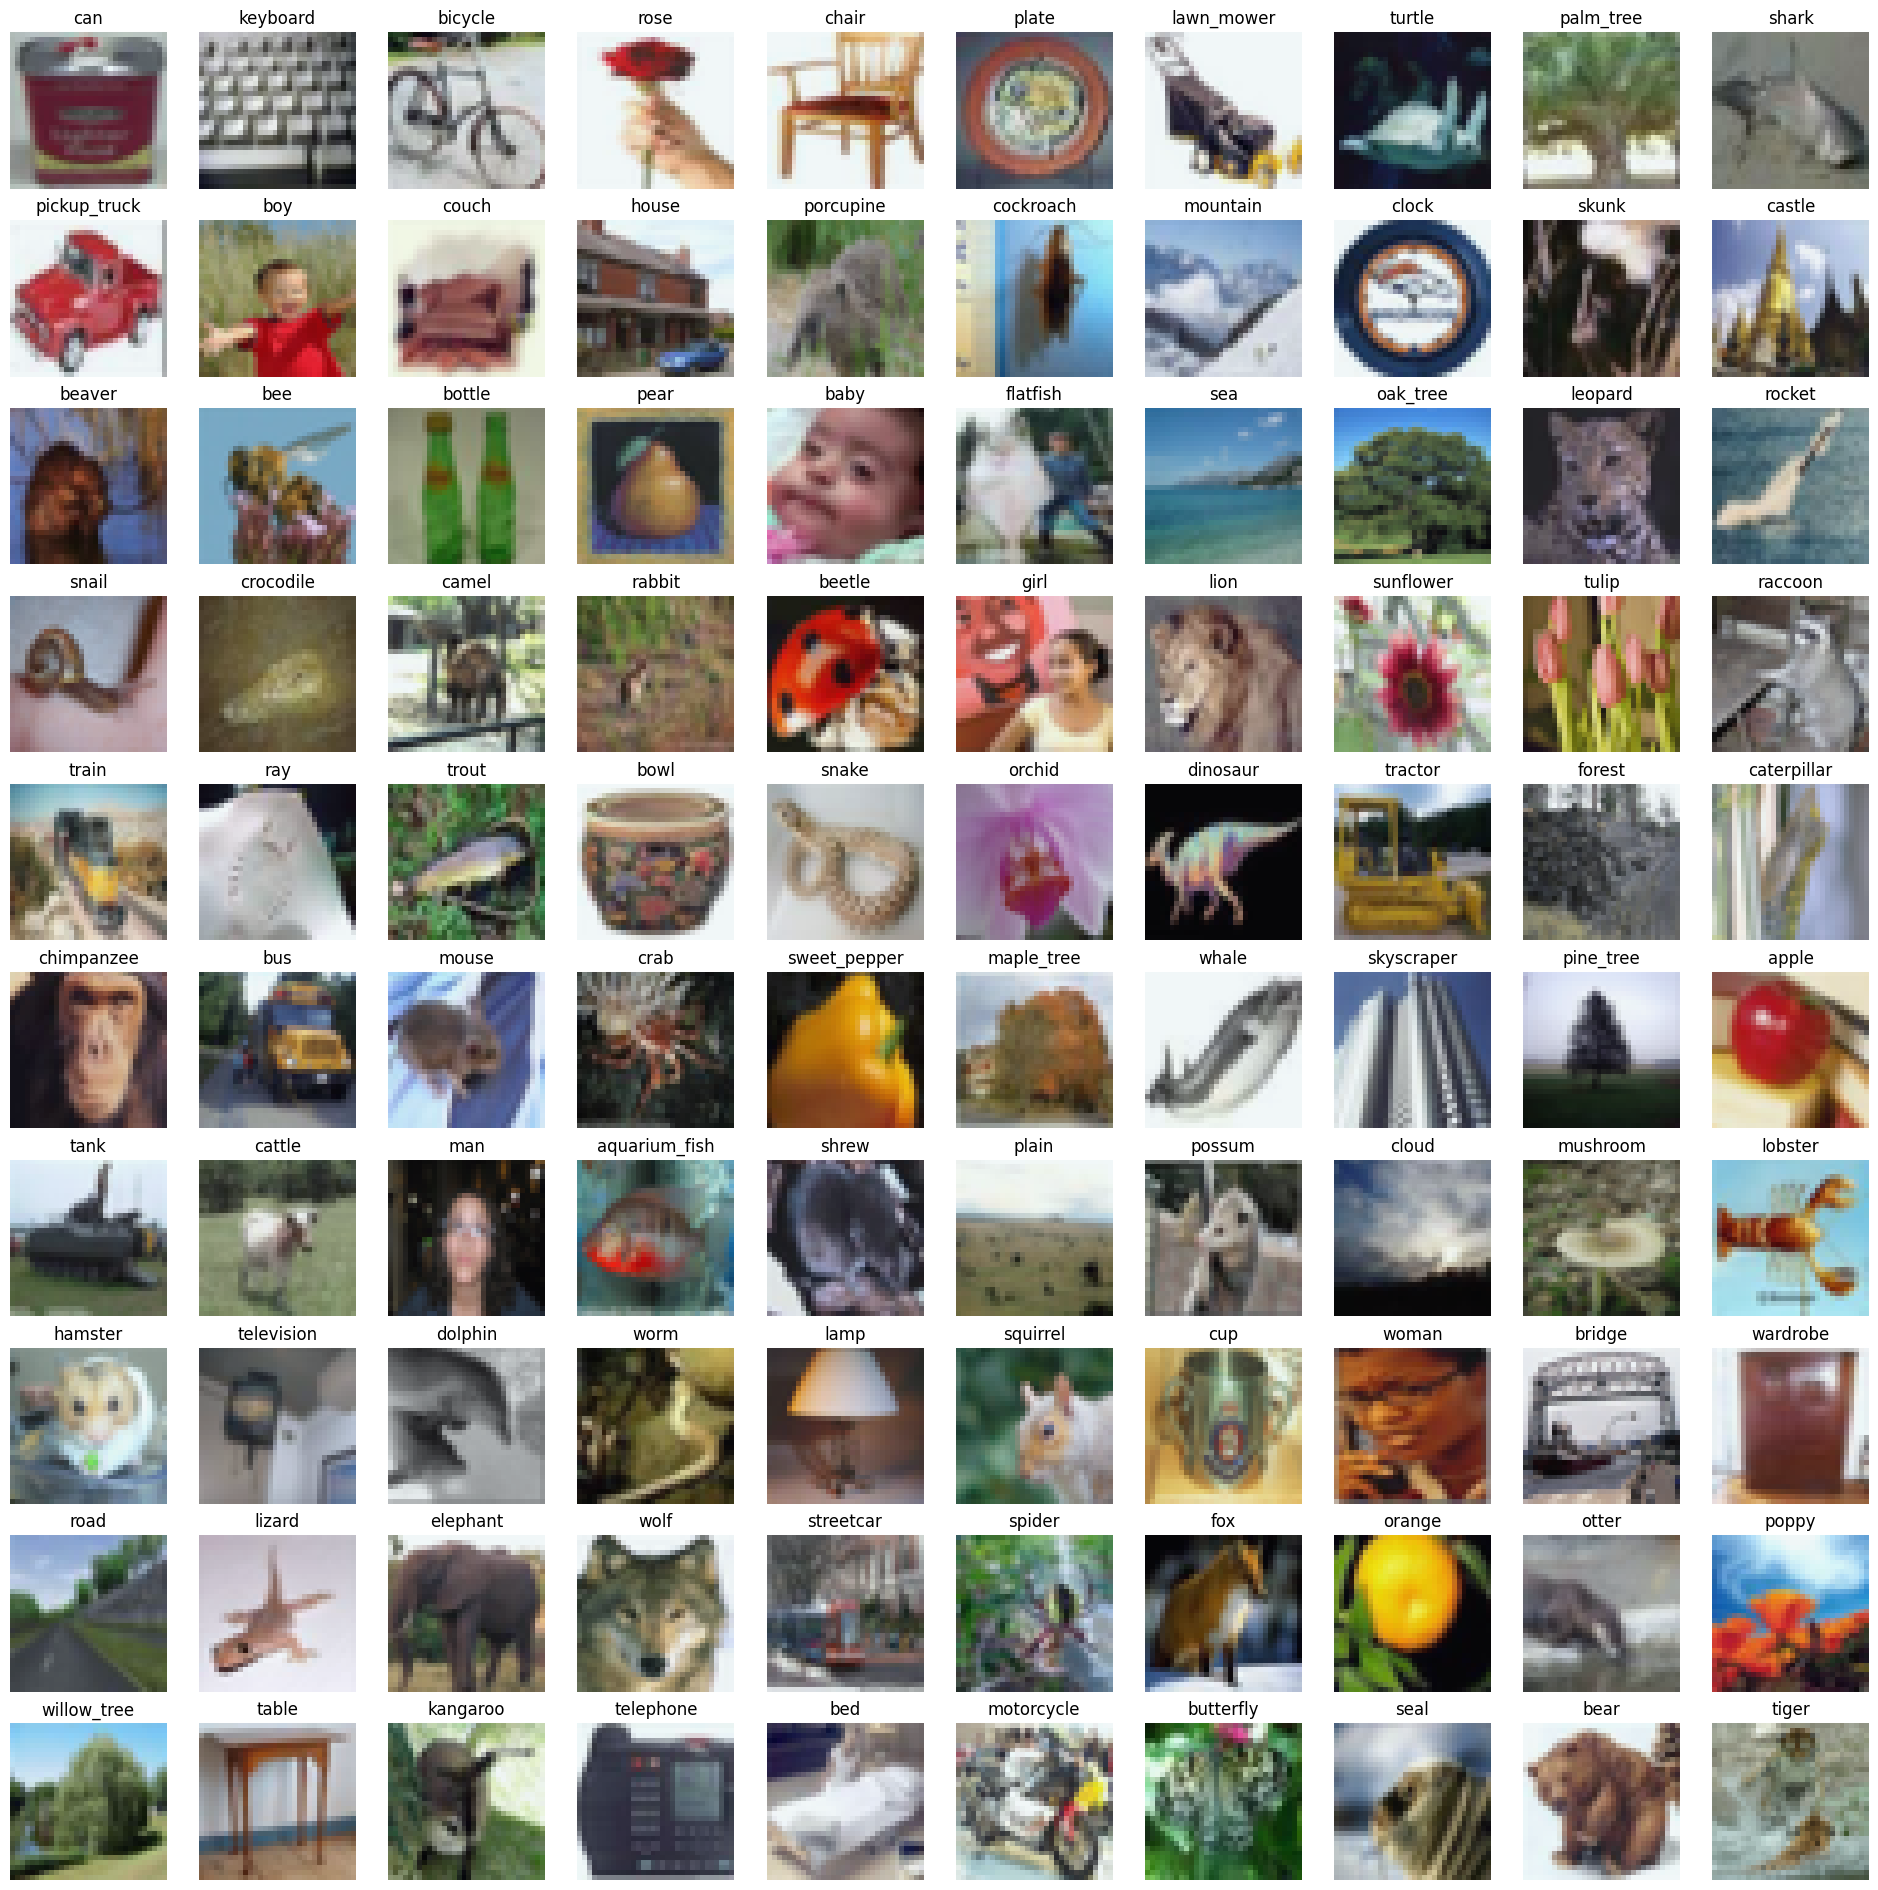

In [ ]:
grid_plot(ground_truth, [validloader.dataset.classes[l] for l in labels]);
#print([validloader.dataset.classes[l] for l in labels]);

In [ ]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

In [ ]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=4,
              max_iterations=2000,
              total_variation=1e-2,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

It: 0. Rec. loss: 0.7647.
It: 500. Rec. loss: 0.0640.
It: 1000. Rec. loss: 0.0383.
It: 1500. Rec. loss: 0.0345.
It: 1999. Rec. loss: 0.0324.
It: 0. Rec. loss: 0.7635.
It: 500. Rec. loss: 0.0690.
It: 1000. Rec. loss: 0.0374.
It: 1500. Rec. loss: 0.0323.
It: 1999. Rec. loss: 0.0308.
It: 0. Rec. loss: 0.7758.
It: 500. Rec. loss: 0.0636.
It: 1000. Rec. loss: 0.0379.
It: 1500. Rec. loss: 0.0321.
It: 1999. Rec. loss: 0.0308.
It: 0. Rec. loss: 0.7476.
It: 500. Rec. loss: 0.0631.
It: 1000. Rec. loss: 0.0377.
It: 1500. Rec. loss: 0.0321.
It: 1999. Rec. loss: 0.0310.
Choosing optimal result ...
Optimal result score: 0.0229
Total time: 17980.821028470993.


Rec. loss: 0.0229 | MSE: 1.5061 | PSNR: 10.56 | FMSE: 5.4476e+00 |


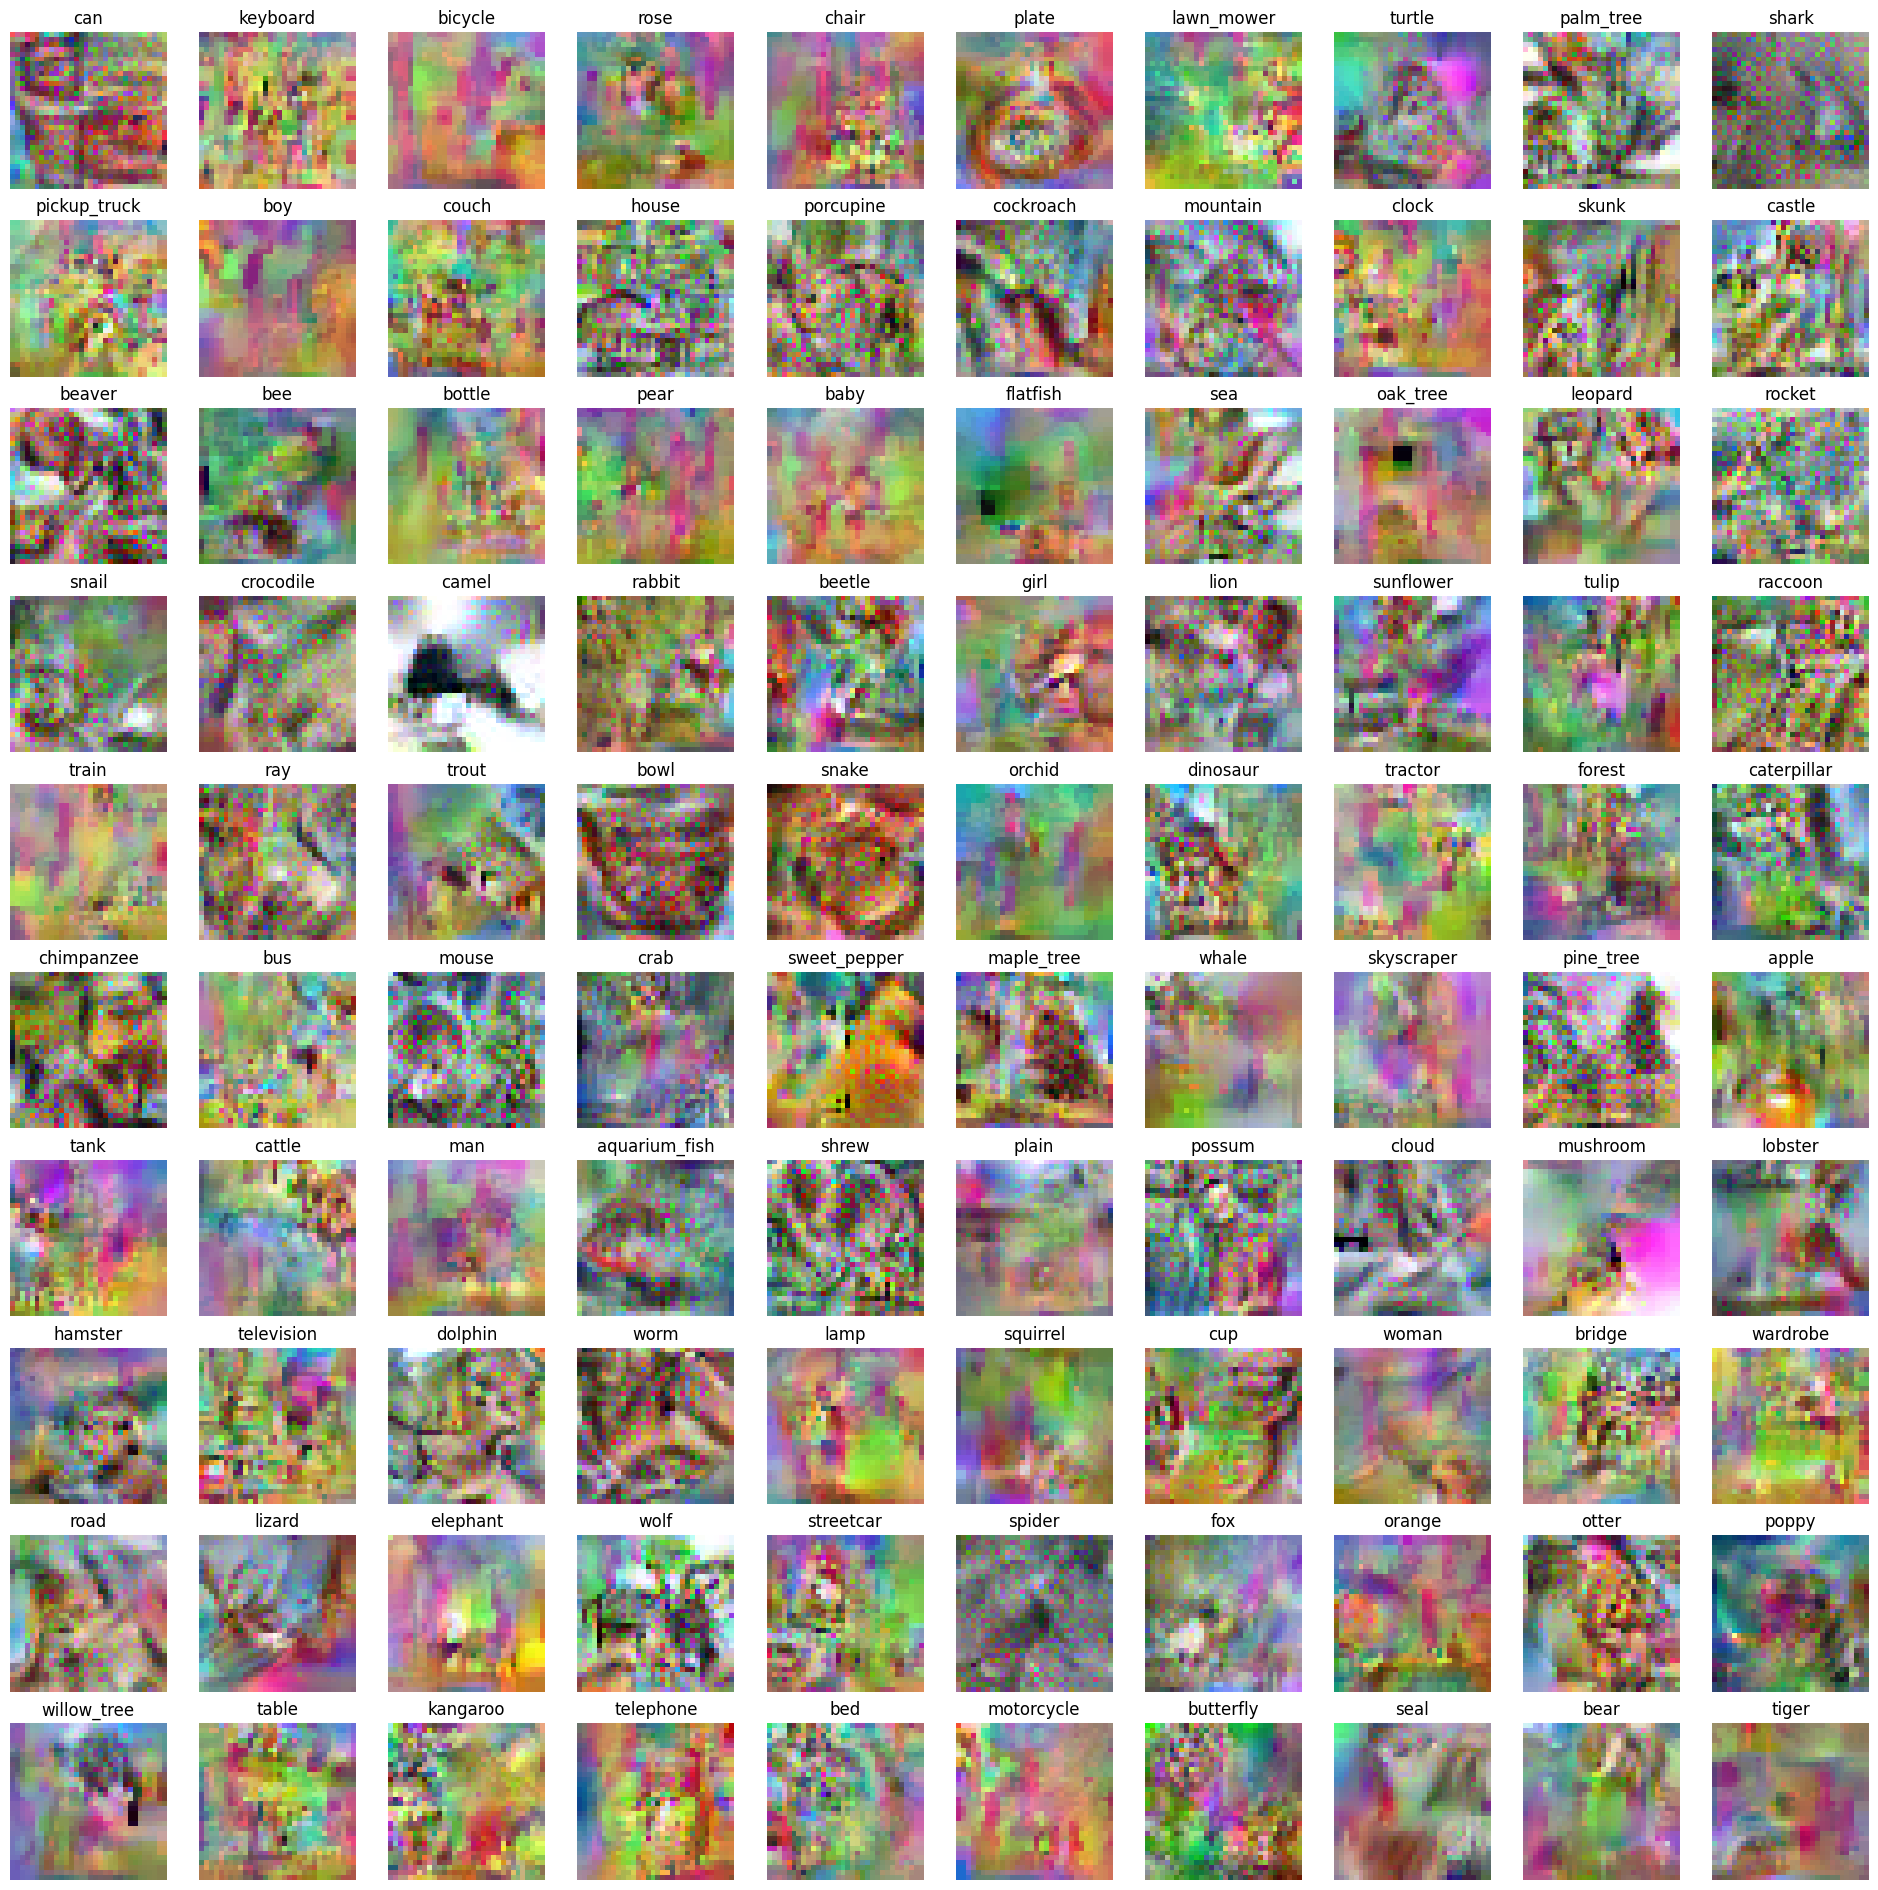

In [ ]:
test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)
grid_plot(output, [validloader.dataset.classes[l] for l in labels]);
print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
      f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

Which classes break privacy depends on the initialization and state of the network.

### Noteworthy classes where privacy was broken in this run:

* trout
* bowl
* cockroach
* rocket
* sweet_pepper
* maple_tree
* willow_tree